In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.common.by import By
import time
from bs4 import BeautifulSoup
import re
import os
from matplotlib import pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
from datetime import datetime

usuario = os.getenv("usuario")
senha = os.getenv("senha")

headers={'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36'}



In [2]:
chrome_options = Options()
# chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--log-level=3')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_experimental_option('excludeSwitches', ['enable-logging'])


In [ ]:
service = Service(executable_path=ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

url = "https://www.instagram.com/p/CqJeJ_FgFxP/"
driver.get(url)
driver.implicitly_wait(20)
driver.maximize_window()
time.sleep(3)

WebDriverWait(driver, 10).until(ec.element_to_be_clickable(
    (By.XPATH, "/html/body/div[2]/div/div/div[1]/div/div/div/div[1]/section/nav/div[2]/div/div/div[3]/div/div[2]/div[1]/a/button"))).click()

caixa_usuario = driver.find_element("xpath", "/html/body/div[2]/div/div/div[1]/div/div/div/div[1]/section/main/div/div/div[1]/div[2]/form/div/div[1]/div/label/input")
caixa_usuario.send_keys(usuario)

caixa_senha = driver.find_element("xpath", "/html/body/div[2]/div/div/div[1]/div/div/div/div[1]/section/main/div/div/div[1]/div[2]/form/div/div[2]/div/label/input")
caixa_senha.send_keys(senha)
time.sleep(3)
WebDriverWait(driver, 10).until(ec.element_to_be_clickable(
    (By.XPATH, "/html/body/div[2]/div/div/div[1]/div/div/div/div[1]/section/main/div/div/div[1]/div[2]/form/div/div[3]/button"))).click() 
time.sleep(3)
WebDriverWait(driver, 10).until(ec.element_to_be_clickable(
    (By.XPATH, "/html/body/div[2]/div/div/div[1]/div/div/div/div[1]/div[1]/div[2]/section/main/div/div/div/section/div/button"))).click() 

time.sleep(3)

while True:
    try:
        WebDriverWait(driver, 10).until(ec.element_to_be_clickable(
            (By.XPATH, "/html/body/div[2]/div/div/div[1]/div/div/div/div[1]/div[1]/div[2]/section/main/div[1]/div[1]/article/div/div[2]/div/div[2]/div[1]/ul/li/div/button"))).click() 
    except Exception as error:
        print(error)
        break

inspect = '/html/body/div[2]/div/div/div[1]/div/div/div/div[1]/div[1]/div[2]/section/main/div[1]/div[1]/article/div/div[2]/div/div[2]/div[1]'

element = driver.find_element('xpath', f'{inspect}')
html_element = element.get_attribute('outerHTML')
soup = BeautifulSoup(html_element, 'html.parser')

In [ ]:
lista_bloco = soup.find_all('ul',"_a9ym")

lista_numeros = []
lista_textos = []
lista_user = []
lista_data = []
for i,bloco in enumerate(lista_bloco):
    numero = re.compile(r'\d+')
    comentarios = bloco.find("span","_aacl _aaco _aacu _aacx _aad7 _aade").text
    numeros = numero.findall(comentarios)
    dias = bloco.find("time", "_a9ze _a9zf")['datetime']
    nome = bloco.find("h3","_a9zc").text

    if len(numeros) == 1:
        lista_numeros.append(numeros[0])
        lista_textos.append(comentarios)
        lista_user.append(nome)
        lista_data.append(dias)

df = pd.DataFrame(list(zip(lista_user,lista_numeros,lista_textos,lista_data)), columns=['user','numeros','comentarios',"data"])

df.to_csv("comentarios.csv")

In [2]:
df = pd.read_csv('comentarios.csv')

df = df.drop('Unnamed: 0', axis = 1)

date_format = "%d/%m/%Y %H:%M:%S"

df['data'] = df['data'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
df['data'] = df['data'].apply(lambda x: x.strftime(date_format))

df.drop_duplicates('user', inplace=True)

df

,user,numeros,comentarios,data
0,gustavo_amorimreis,539,"Tem 539, extrai todos os comentarios em uma pl...",24/03/2023 01:10:42
1,klausbalzano,432,"432, confia",23/03/2023 22:50:56
2,danielsoares_gec,583,"583, eu vou acertar pode anotar aí",28/03/2023 19:26:03
3,clerinhob,323,323 👏,25/03/2023 15:58:14
4,michellrupp,429,429 . Acho que todo mundo tentou fazer mais ou...,24/03/2023 10:33:52
...,...,...,...,...
3991,lealeal99,126,Tem exatamente 126,23/03/2023 22:34:07
3992,kennyamada,225,225,23/03/2023 22:34:10
3993,af121739,148,148,23/03/2023 22:34:11
3994,marcelobet77,832,832,23/03/2023 22:34:28


### Moda, ganhadores, último dígito que mais aparece e números pares/ímpares

In [3]:
df['numeros'] = df['numeros'].astype("int64")
moda = df['numeros'].mode()
print(moda)

0    540
Name: numeros, dtype: int64


In [4]:
pessoas_que_acertaram = df[df['numeros'] == 436]
pessoas_que_acertaram.sort_values("data")

,user,numeros,comentarios,data
3891,ricardomachado_rm,436,436,23/03/2023 22:30:04
3029,alcedomedeiros,436,436,23/03/2023 23:12:27
3263,danniloarruda,436,436,23/03/2023 23:40:25
2973,_luizakist,436,436,24/03/2023 02:03:08
1189,lucianacristinagoncalves,436,436 confetes,25/03/2023 12:36:54
1415,evertonpereira195,436,436,26/03/2023 00:11:14
851,marceljurado1,436,Tem 436,26/03/2023 23:13:50
871,brenoovieira,436,436,27/03/2023 00:42:59


In [5]:
df['ultimo_digito'] = df['numeros'].astype(str).str.strip().str[-1]
ultimos_digitos = df.groupby("ultimo_digito").count()['numeros']

ultimos_digitos


ultimo_digito
0    906
1    205
2    438
3    324
4    331
5    325
6    300
7    414
8    356
9    211
Name: numeros, dtype: int64

In [6]:
df['paridade'] =  df['numeros'] % 2

pares = df.loc[df['paridade'] == 0, 'numeros']

impares = df.loc[df['paridade'] == 1, 'numeros']

print("Números pares: ", len(pares), "Números impares: ", len(impares))

Números pares:  2331 Números impares:  1479


# Tratando a amostra pra calculo de média

In [7]:
def tryconvert(value, default, *types):
    for t in types:
        try:
            return t(value)
        except (ValueError, TypeError):
            continue
    return default

In [8]:
#cropando a amostra no que a gente precisa 

numeros = df['numeros']

numeros = numeros.apply(lambda x: tryconvert(x, pd.NA, int))

numeros = numeros.dropna()

numeros = numeros.apply(lambda x: x if x <= 1500 else pd.NA)

numeros = numeros.dropna()


In [9]:
print(f"Tamanho da amostra: {numeros.count()}") #tamanho da amostra
print(f"Média dos resultados: {numeros.mean()}") #media da amostra
print(f"Desvio padrão: {numeros.std()}") #desvio padrão 

Tamanho da amostra: 3760
Média dos resultados: 436.2851063829787
Desvio padrão: 207.95569798399615


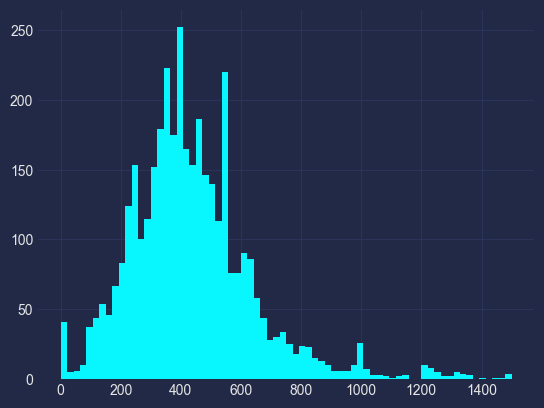

In [10]:
valores = numeros.values
plt.hist(valores, bins = 70)
plt.show()